## Preparing for sentiment Analysis using BERT

In [1]:
#Import packages
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

#Set working directory
cwd = os.getcwd()

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Import the dataframes
df_comment = pd.read_csv(cwd+"/data/Comment_dataset_processed.csv")
df_submission = pd.read_csv(cwd+"/data/Post_dataset_processed.csv")

In [3]:
#Import the tokenized and model
tokenizer = AutoTokenizer.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis")
model = TFAutoModelForSequenceClassification.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis") #needs pip install emoji==0.6.0

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at rabindralamsal/finetuned-bertweet-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


### Preprocessing
The maximum length per comment that the model can handle is 130, since it is based on Tweets. However, based on the distribution of the length of the comment. About 38 percent of the comments would not be able to be processed by this model.

The second graph shows the percentage of comments per post that would stay in the same if we deleted comments that are too long.

Percentage of rows that exceed a length of 130:  0.38434337351258036


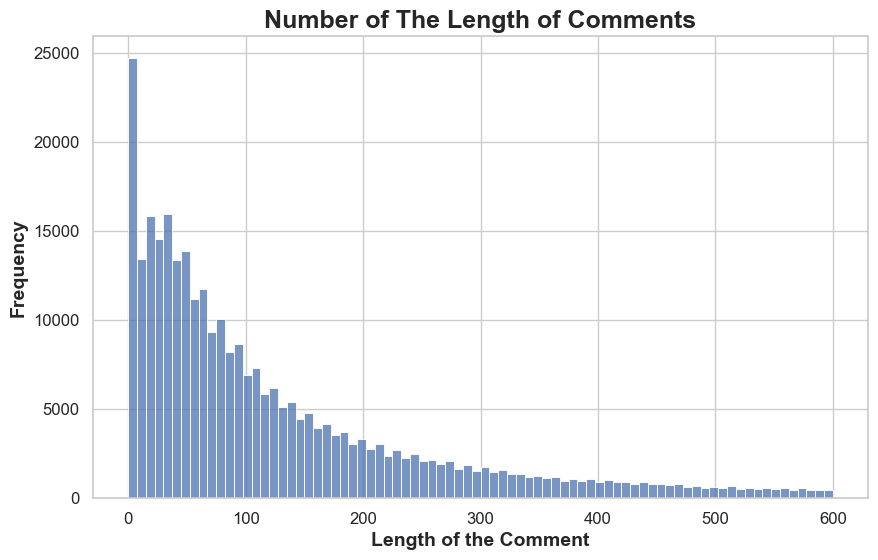

In [4]:
#Printing the percentage of rows that exceed a length of 130
print("Percentage of rows that exceed a length of 130: ", len(df_comment[df_comment['Comment Text'].str.len() > 130])/len(df_comment))

#Plotting the histogram of the remaining comments
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment['Comment Text'].str.len(), bins=80, kde=False, binrange=[0, 600])

plt.xlabel('Length of the Comment', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Number of The Length of Comments' , fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


Percentage of comments that exceed a length of 130:  0.38434337351258036


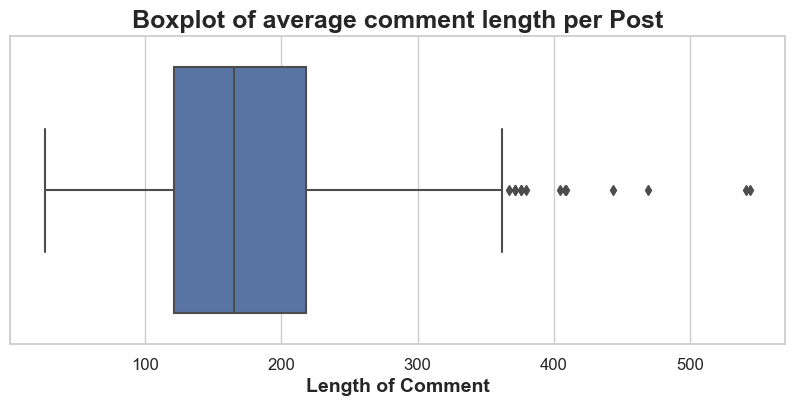

In [5]:
#Printing the percentage of rows that exceed a length of 130
print("Percentage of comments that exceed a length of 130: ", len(df_comment[df_comment['Comment Text'].str.len() > 130])/len(df_comment))

#The average lentgh of the comments per post
avg_length = df_comment['Comment Text'].str.len().groupby(df_comment['ID of Post']).mean()

#Plotting the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(x=avg_length)

plt.xlabel('Length of Comment', fontsize=14, fontweight='bold')
plt.title('Boxplot of average comment length per Post', fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


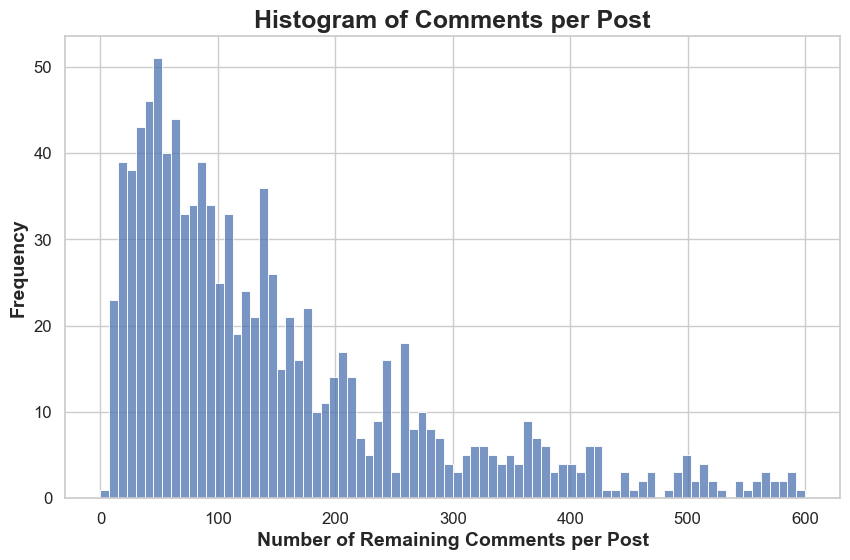

In [38]:
#Removing all the comments that exceed a length of 130 and save to a new dataset
df_comment_short = df_comment[df_comment['Comment Text'].str.len() < 130]

#Plotting the histogram of the remaining comments
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment_short['Comment Text'].groupby(df_comment_short['ID of Post']).count(), bins=80, kde=False, binrange=[0, 600])

plt.xlabel('Number of Remaining Comments per Post', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Histogram of Comments per Post', fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Getting the sentiment score

In [7]:
#To explain how it works, we will use the following sentence:
sentence = "[Official] ChatGPT now supports plugins!!!	"
sentence = sentence.lower()
#We will use the tokenizer to encode the sentence
input = tokenizer.encode(sentence, return_tensors="tf")
#We will use the model to predict the sentiment
tf.nn.sigmoid(model.predict(input)[0][0]).numpy()

1/1 [==============================] - 4s 4s/step


array([0.01938847, 0.8629473 , 0.83901477], dtype=float32)

The array shown above shows the probability of the sentence being negative, neutral or positive (in that order). The sentence has a high probability of being positive. However, the probability of neutral is even higher.
The final label of that sentence would be neutral. Since there are a lot of neutral sentences in the database, the decision has been made to base the sentiment upon the amount of negative versus positive probability.
This means that the final sentiment will be a sum of the product of negative probability times -1, and the product of positive probability times 1.
The following calculates this sentiment.


In [51]:
#Getting the sentiment score for the comments
def sentiment_score(df_file: pd.DataFrame, column_name: str, batch_size: int):
    """
    Assign a preprocessed dataframe to df_file
    Assign a single column name to column_name for the text to be used for sentiment analysis
    Assign a batch size to batch_size for processing in batches
    Applies the classify function to the column_name using a batch size
    Returns a dataframe with a new column "Sentiment" with the sentiment score
    """
    sentiment = []
    negative = []
    neutral = []
    positive = []
    n = len(df_file)
    num_batches = n // batch_size + int(n % batch_size != 0)
    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, n)
        batch = df_file.iloc[start:end][column_name].values.tolist()
        try:
            inputs = tokenizer(batch, return_tensors="tf", padding=True, truncation=True)
        except:
            print("Error at", i * batch_size)

        inputs = {key: tuple(value.numpy().tolist()) for key, value in inputs.items()} 
        inputs = inputs["input_ids"]
        with tf.device('/gpu:0'):
            predictions = model.predict(inputs)["logits"]
        probabilities = tf.nn.sigmoid(predictions).numpy()
        sentiment.extend([prob[2] - prob[0] for prob in probabilities])
        negative.extend([prob[0] for prob in probabilities])
        neutral.extend([prob[1] for prob in probabilities])
        positive.extend([prob[2] for prob in probabilities])
            
    df_file["Sentiment"] = sentiment
    df_file["Negative"] = negative
    df_file["Neutral"] = neutral
    df_file["Positive"] = positive
    return df_file

#Calling the function
df_submission_score = sentiment_score(df_file=df_comment_short, column_name="Comment Text", batch_size=50000)
df_submission_score.to_csv(cwd+"/data/Comment_sentiment_score_daim_new.csv", index=False)

1519/1519 [==============================] - 220s 145ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26156\1601457455.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_file["Sentiment"] = sentiment
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26156\1601457455.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_file["Negative"] = negative
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26156\1601457455.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [92]:
df_submission_score = pd.read_csv(cwd+"/data/Comment_sentiment_score_daim.csv")
df_submission_score["binary_sentiment"] = np.where(df_submission_score["Sentiment"] > 0.5, 1, 0)

In [110]:
df_submission_score.iloc[126]

Subreddit                       ChatGPT
ID of Post                       zdjpyi
Comment Text                 Holy crap!
Score                                 6
Author                   Delwyn_dodwick
Date & Time         2022-12-06 18:53:48
Length Comment                     10.0
Sentiment                     -0.248189
Negative                       0.508267
Neutral                        0.684086
Positive                       0.260078
binary_sentiment                      0
Date                         2022-12-06
Name: 88872, dtype: object

In [94]:
df_submission_score.sort_values(by=["Date & Time"], inplace=True)

In [95]:
# Add a column that extracts the date from the datetime column:
df_submission_score['Date'] = pd.to_datetime(df_submission_score['Date & Time']).dt.date



In [96]:
# create a new dataset with 4 columns, every row is a unique day, and the columns are the average sentiment score, negative, neutral and positive:
df_submission_score_daily = df_submission_score.groupby(['Date']).mean().reset_index()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26156\6175736.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_submission_score_daily = df_submission_score.groupby(['Date']).mean().reset_index()


In [98]:
df_submission_score_daily

,Date,Score,Length Comment,Sentiment,Negative,Neutral,Positive,binary_sentiment
0,2022-12-03,7.333333,51.833333,-0.226226,0.485309,0.743324,0.259083,0.250000
1,2022-12-04,6.666667,54.916667,0.291351,0.263217,0.687148,0.554569,0.500000
2,2022-12-05,67.613636,50.613636,0.086173,0.292532,0.804827,0.378705,0.250000
3,2022-12-06,21.516129,40.956989,0.244725,0.186658,0.839778,0.431383,0.225806
4,2022-12-07,17.049689,51.490683,0.165090,0.226678,0.852053,0.391768,0.155280
...,...,...,...,...,...,...,...,...
146,2023-04-28,1.067227,49.344538,0.118932,0.264496,0.827895,0.383428,0.226891
147,2023-04-29,1.087719,43.228070,0.153846,0.261496,0.816605,0.415342,0.298246
148,2023-04-30,1.074074,41.203704,0.224626,0.201608,0.845093,0.426234,0.240741
149,2023-05-01,1.034483,51.000000,0.165506,0.257808,0.810104,0.423314,0.327586


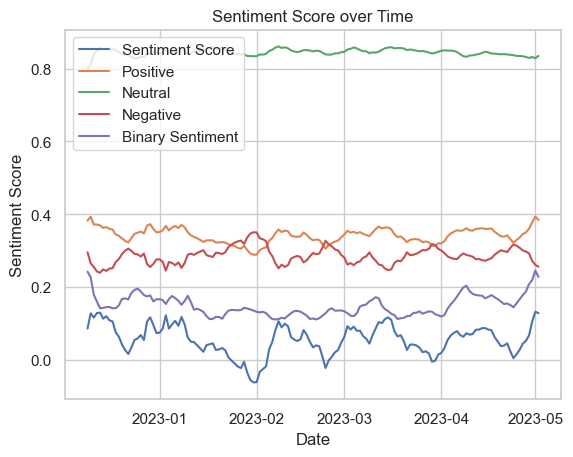

In [103]:
plt.plot(df_submission_score_daily['Date'], df_submission_score_daily['Sentiment'].rolling(window=7).mean(), label='Sentiment Score')
plt.plot(df_submission_score_daily['Date'], df_submission_score_daily['Positive'].rolling(window=7).mean(), label='Positive')
plt.plot(df_submission_score_daily['Date'], df_submission_score_daily['Neutral'].rolling(window=7).mean(), label='Neutral')
plt.plot(df_submission_score_daily['Date'], df_submission_score_daily['Negative'].rolling(window=7).mean(), label='Negative')
plt.plot(df_submission_score_daily['Date'], df_submission_score_daily['binary_sentiment'].rolling(window=7).mean(), label='Binary Sentiment')
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score over Time')
plt.show()

### Exploring the results

In [53]:
#Visualizing the results
print(f"What the sentiment score looks like:\n{df_submission_score[['Comment Text', 'Sentiment']].head()}\n")
print(f"Some information about the sentiment score:\n{df_submission_score['Sentiment'].describe()}\n")

What the sentiment score looks like:
                                      Comment Text  Sentiment
0  Recognizing ASCII shrek is the last step to AGI   0.393246
1                             That's  , green icon   0.462885
2                                It’s not   though   0.458201
3                                    This is not     0.442465
5                            thinks otherwise\n\n    0.483954

Some information about the sentiment score:
count    198603.000000
mean          0.168751
std           0.454901
min          -0.902328
25%          -0.134650
50%           0.395358
75%           0.459367
max           0.948948
Name: Sentiment, dtype: float64



In [ ]:
# DAIM 

#Visualizing the results
print(f"What the sentiment score looks like:\n{df_submission_score[['Comment Text', 'Sentiment', 'negative', 'neutral', 'positive']].head()}\n")
print(f"Some information about the sentiment score:\n{df_submission_score['Sentiment'].describe()}\n")
print(f"negative score:\n{df_submission_score['negative'].describe()}\n")
print(f"neutral:\n{df_submission_score['neutral'].describe()}\n")
print(f"positive:\n{df_submission_score['positive'].describe()}\n")

In [38]:
#look at the comment text with the highest and lowest sentiment score
print(df_submission_score[df_submission_score['Sentiment'] == df_submission_score['Sentiment'].max()]['Comment Text'])
#Thanks. I might pick it up again. At the moment my creative focus is on my writing but diversifying my skillset is never bad.

print(df_submission_score[df_submission_score['Sentiment'] == df_submission_score['Sentiment'].min()]['Comment Text'])
#How a report can be made? It seems to me an abuse of power

317115    Thanks. I might pick it up again. At the momen...
Name: Comment Text, dtype: object
171126    How a report can be made? It seems to me an ab...
Name: Comment Text, dtype: object


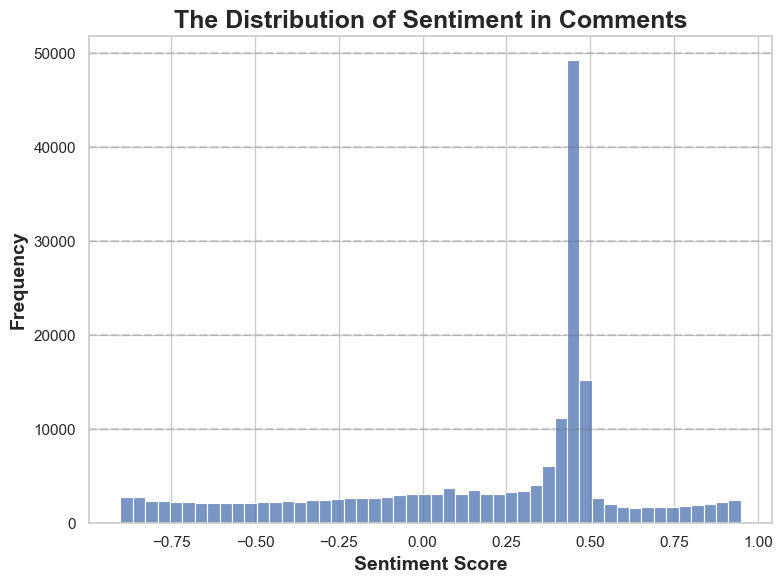

In [33]:
#Plotting the distribution of the sentiment score
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_submission_score, x='Sentiment', bins=50, kde=False, ax=ax)

plt.xlabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('The Distribution of Sentiment in Comments' , fontsize=18, fontweight='bold')

for y in ax.get_yticks()[1:-1]:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

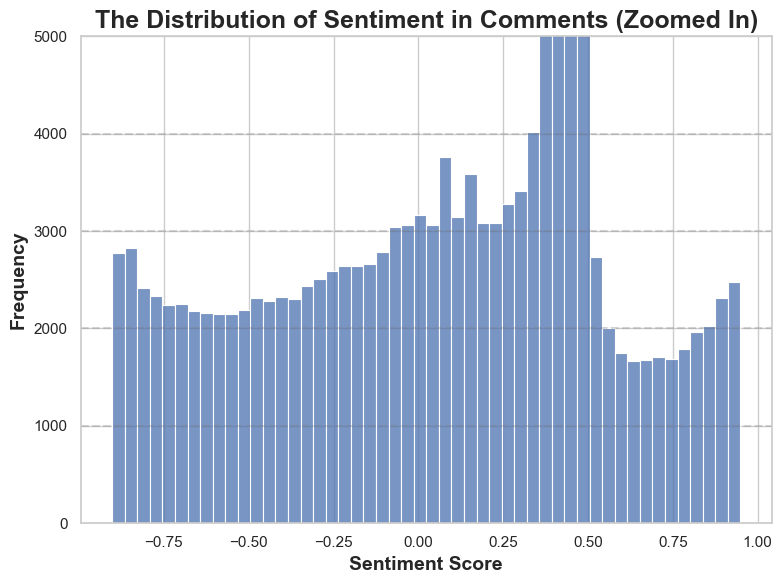

In [34]:
#Zooming the plot in to get more detailed information
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_submission_score, x='Sentiment', bins=50, kde=False, ax=ax)

ax.set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_title('The Distribution of Sentiment in Comments (Zoomed In)', fontsize=18, fontweight='bold')

ax.set_ylim(0, 5000) #to zoom in

for y in ax.get_yticks()[1:-1]:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
def sentiment_label(df_file: pd.DataFrame, column_name: str, batch_size: int):
    """
    Assign a preprocessed dataframe to df_file
    Assign a single column name to column_name for the text to be used for sentiment analysis
    Assign a batch size to batch_size for processing in batches
    Applies the classify function to the column_name using a batch size
    Returns a dataframe with a new column "Sentiment" with the sentiment label
    """
    df_file["Sentiment"] = 0
    n = len(df_file)
    num_batches = n // batch_size + int(n % batch_size != 0)
    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, n)
        batch = df_file.iloc[start:end][column_name].values.tolist()
        inputs = tokenizer(batch, return_tensors="tf", padding=True, truncation=True)
        inputs = {key: tuple(value.numpy().tolist()) for key, value in inputs.items()} 
        inputs = inputs["input_ids"]
        with tf.device('/gpu:0'):
            predictions = model.predict(inputs)["logits"]
        probabilities = tf.nn.softmax(predictions, axis=1).numpy()
        for j in range(len(probabilities)):
            sentiment = np.argmax(probabilities[j])
            df_file.iloc[start + j, df_file.columns.get_loc("Sentiment")] = sentiment
    return df_file

df_sentiment_label = sentiment_label(df_file=df_comment_short, column_name="Comment Text", batch_size=128)
df_sentiment_label.to_csv(cwd+"/data/Comment_sentiment_label.csv", index=False)


C:\Users\noort\AppData\Local\Temp\ipykernel_14264\253245463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_file["Sentiment"] = 0


3/3 [==============================] - 0s 79ms/step


In [45]:
print(f"What the sentiment score looks like:\n{df_sentiment_label[['Comment Text', 'Sentiment']].head()}\n")

What the sentiment score looks like:
                                      Comment Text  Sentiment
0  Recognizing ASCII shrek is the last step to AGI          1
1                             That's  , green icon          1
2                                It’s not   though          1
3                                    This is not            1
5                            thinks otherwise\n\n           1



In [46]:
#percentage of the labels
print(f"Percentage of label negative in dataset: {len(df_sentiment_label[df_sentiment_label['Sentiment'] == 0])/len(df_sentiment_label)*100:.2f}")
print(f"Percentage of label neutral in dataset: {len(df_sentiment_label[df_sentiment_label['Sentiment'] == 1])/len(df_sentiment_label)*100:.2f}")
print(f"Percentage of label positive in dataset: {len(df_sentiment_label[df_sentiment_label['Sentiment'] == 2])/len(df_sentiment_label)*100:.2f}")


Percentage of label negative in dataset: 7.11
Percentage of label neutral in dataset: 87.15
Percentage of label positive in dataset: 5.74


In [39]:
print(f"Percentage of negative sentiment scores between -1 and -0.5: {len(df_submission_score[(df_submission_score['Sentiment'] >= -1) & (df_submission_score['Sentiment'] < -0.5)])/len(df_submission_score)*100:.2f}")
print(f"Percentage of neutral sentiment scores between -0.5 and 0.5: {len(df_submission_score[(df_submission_score['Sentiment'] >= -0.5) & (df_submission_score['Sentiment'] <= 0.5)])/len(df_submission_score)*100:.2f}")
print(f"Percentage of positive sentiment scores between 0.5 and 1: {len(df_submission_score[(df_submission_score['Sentiment'] > 0.5) & (df_submission_score['Sentiment'] <= 1)])/len(df_submission_score)*100:.2f}")


Percentage of negative sentiment scores between -1 and -0.5: 12.79
Percentage of neutral sentiment scores between -0.5 and 0.5: 75.00
Percentage of positive sentiment scores between 0.5 and 1: 12.21


In [7]:
df_submission_score = pd.read_csv(cwd+"/data/Comment_dataset_sentiment.csv")

In [13]:
df_submission_score.iloc[0:10]

,Subreddit,ID of Post,Comment Text,Score,Author,Date & Time,Length Comment,Sentiment
0,ChatGPT,12cobqr,Recognizing ASCII shrek is the last step to AGI,2180,EwaldvonKleist,2023-04-05 18:30:30,47.0,0.393246
1,ChatGPT,12cobqr,"That's , green icon",644,anonymoose137,2023-04-05 18:35:14,20.0,0.462885
2,ChatGPT,12cobqr,It’s not though,358,I_am_purrfect,2023-04-05 18:31:39,17.0,0.458201
3,ChatGPT,12cobqr,This is not,526,vitorgrs,2023-04-05 18:38:06,13.0,0.442465
4,ChatGPT,12cobqr,thinks otherwise\n\n,68,Giblaz,2023-04-05 20:40:43,21.0,0.483954
5,ChatGPT,12cobqr,Famous: yes\n\nMona Lisa: absolutely,53,Ghost_Flame69,2023-04-05 18:07:09,34.0,0.414022
6,ChatGPT,12cobqr,,74,NaN,2023-04-05 21:19:10,1.0,0.039516
7,ChatGPT,12cobqr,I think you discovered a secret way for humans...,29,kemonkey1,2023-04-05 19:13:33,124.0,-0.419979
8,ChatGPT,12cobqr,Whoa it did it!,12,TLo137,2023-04-05 17:56:39,15.0,0.457971
9,ChatGPT,12cobqr,"Yep, definitely ending civilisation",5,senseibull,2023-04-05 20:30:12,35.0,0.475646


## Combining the sentiments results with the topics